In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import six
import tensorflow as tf

from edward.models import (
    Categorical, Dirichlet, Empirical, InverseGamma,
    MultivariateNormalDiag, Normal, ParamMixture, Bernoulli, Multinomial)

import utils
plt.style.use('ggplot')

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
datareader = utils.readmnist(path='MNIST')
data = []
for i in datareader:
    data.append(i)

Xtrain = np.zeros([600, 28*28])
Ytrain = np.zeros(600)

for i in range(600):
    Xtrain[i] = data[i][1].flatten()
    Ytrain[i] = data[i][0]
    
Xmean = Xtrain.mean(axis=0)
Xscale = Xtrain.std(axis=0)
np.place(Xscale, Xscale==0, -1)
Xtrain = (Xtrain-Xmean)/Xscale
np.place(Xscale, Xscale==-1, 0)

In [3]:
M = 10
N = 600
D1 = 25
D2 = 28*28

# model
beta = Dirichlet(tf.ones(M))
mu = Normal(tf.zeros(D1), tf.ones(D1), sample_shape=M)
sigmasq = InverseGamma(tf.ones(D1), tf.ones(D1), sample_shape=M)
z = ParamMixture(beta, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
c = z.cat
wx = Normal(loc=tf.zeros([D2, D1]), scale=tf.ones([D2, D1]))
wy = Normal(loc=tf.zeros([10, D1]), scale=tf.ones([10, D1]))
x = Normal(loc=tf.matmul(z, wx, transpose_b=True), scale=tf.ones([N, D2]))
y = Categorical(logits=tf.matmul(z, wy, transpose_b=True))

In [4]:
# inference
qz = Normal(loc=tf.Variable(tf.random_normal([N, D1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([N, D1]))))
qmu = Normal(loc=tf.Variable(tf.random_normal([M, D1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([M, D1]))))
qwx = Normal(loc=tf.Variable(tf.random_normal([D2, D1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D2, D1]))))
qwy = Normal(loc=tf.Variable(tf.random_normal([10, D1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([10,D1]))))
qc = Categorical(logits=tf.Variable(tf.zeros([N,M])))

inference = ed.KLqp({mu: qmu, c: qc}, data={x: Xtrain, y: Ytrain})
#  , z: qz, wy: qwy, wx: qwx
inference.run(n_iter=1000, n_print=100, n_samples=10)

1000/1000 [100%] ██████████████████████████████ Elapsed: 235s | Loss: 116974016.000


Inferred prototypes axes:


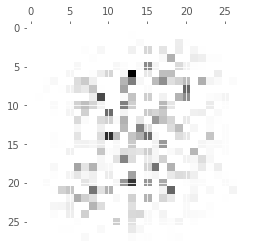

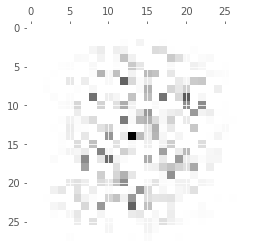

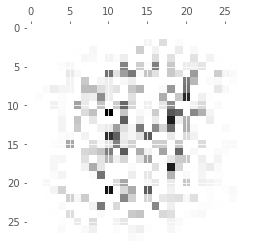

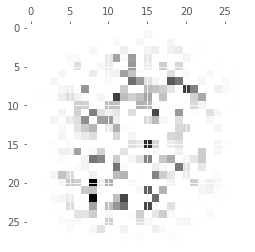

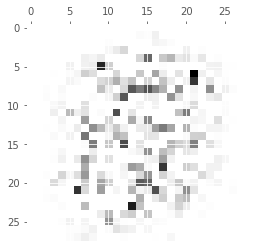

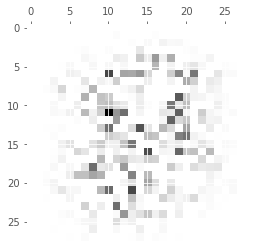

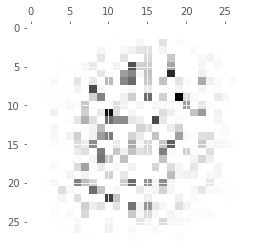

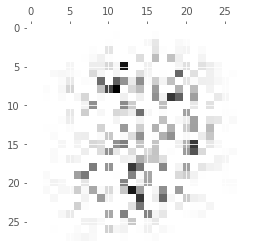

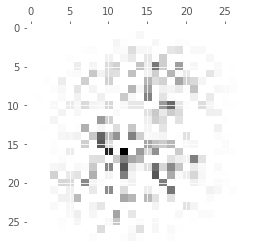

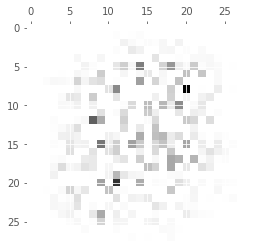

In [6]:
sess = ed.get_session()
print("Inferred prototypes axes:")

zproto = sess.run(qmu.mean())
dictionary = sess.run(qwx.mean())
dictionary = np.matmul(zproto,dictionary.transpose())*Xscale+Xmean
np.place(dictionary, dictionary<0, 0)
for i in range(dictionary.shape[0]):
    utils.show(dictionary[i,:].reshape((28,28)))